Tutorial 2: Mappers
===================

In the previous example, we made a _Mapper_ from a rectangular _Pixelization_. However, it wasn't clear what a _Mapper_
was actually mapping. Infact, it didn't do much mapping at all! Therefore, in this tutorial, we'll cover mapping.

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)lens

Workspace Path:  /home/carlos/autolens_workspace


We'll use new strong lensing data, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's _MassProfile_ is an _EllipticalIsothermal_.
 - The source galaxy's _LightProfile_ is an _EllipticalSersic_.

In [2]:
from howtolens.simulators.chapter_4 import lens_sie__source_sersic

dataset_type = "chapter_4"
dataset_name = "lens_sie__source_sersic"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

Now, lets set up our _Grid_'s (using the image above).

In [3]:
grid = al.Grid.uniform(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=1
)

Our _Tracer_ will use the same lens galaxy and source galaxy that we used to Simulate the Imaging data (although, 
becuase we're modeling the source with a pixel-grid, we don't need to supply its _LightProfile_).

In [105]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.6
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=grid)[1]

Next, we setup our _Pixelization_and _Mapper_ using the tracer's source-plane grid.

In [106]:
rectangular = al.pix.Rectangular(shape=(25, 25))

mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

We're going to plot our _Mapper_ alongside the image we used to generate the source-plane grid.

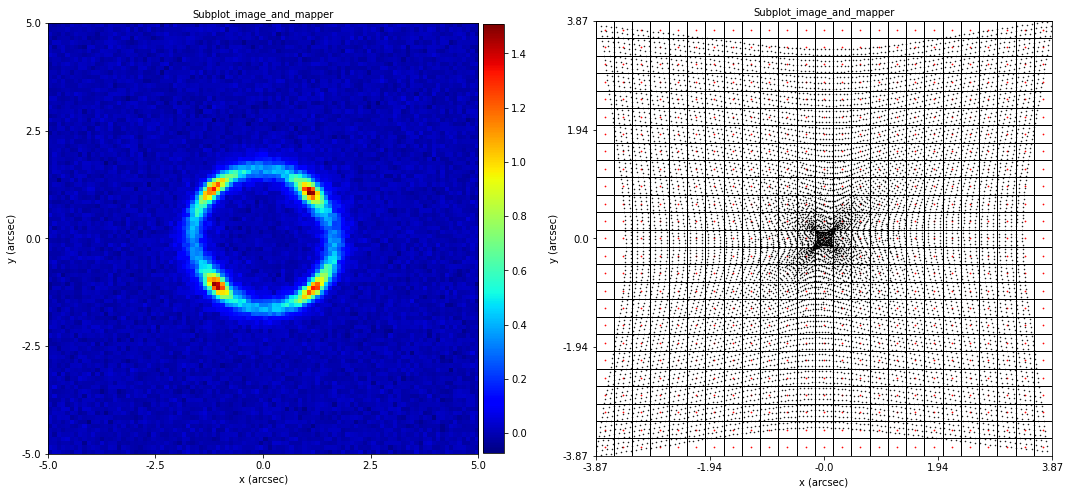

In [107]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image, mapper=mapper, include=aplt.Include(inversion_grid=True)
)

The pixels in the image map to the pixels in the source-plane, and visa-versa. Lets highlight a set of image-pixels in 
both the image and source-plane.

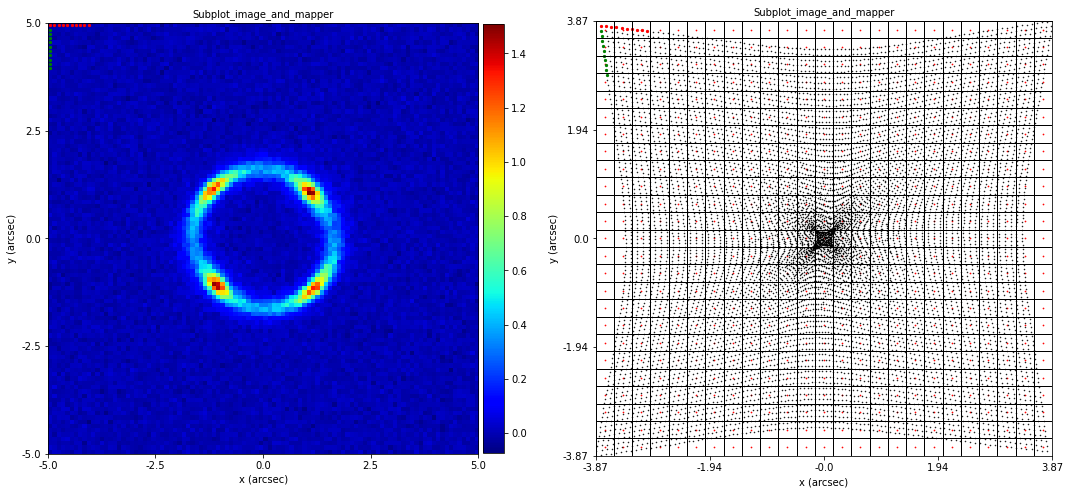

In [108]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(inversion_grid=True),
    image_pixel_indexes=[
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    ],
)

That's nice, and we can see the mappings, but it isn't really what we want to know, is it? We really want to go the 
other way, and see how our source-pixels map to the image. This is where _Mapper_'s come into their own, as they let us 
map all the points in a given source-pixel back to the image. Lets map source pixel 313, the central source-pixel, 
to the image.

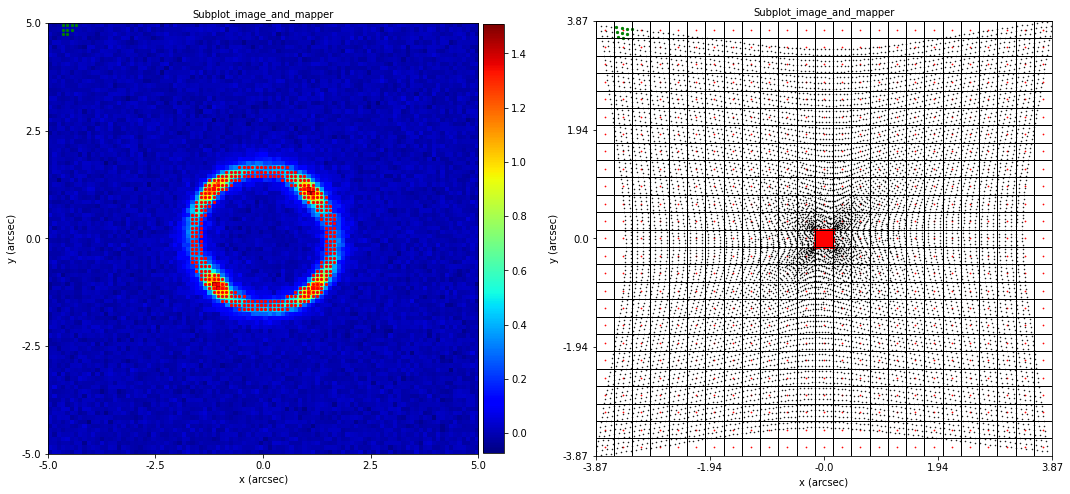

In [109]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(inversion_grid=True),
    source_pixel_indexes=[[312], [1]],
)

And there we have it - multiple _Imaging_ in all its glory. Try changing the source-pixel indexes of the line below. 
This will give you a feel for how different regions of the source-plane map to the image.

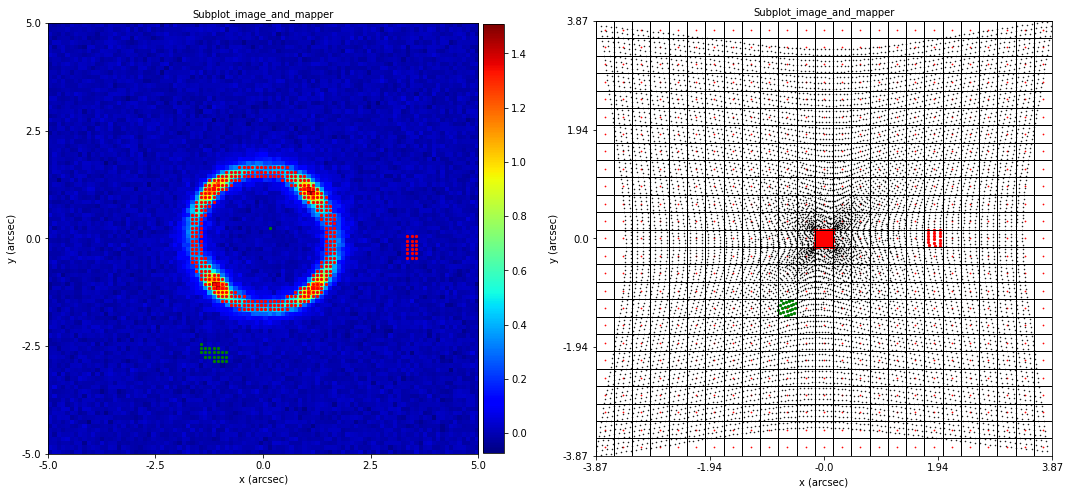

In [110]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(inversion_grid=True),
    source_pixel_indexes=[[312, 318], [410]],
)

Okay, so I think we can agree, _Mapper_'s map things! More specifically, they map our source-plane pixels to pixels in 
the observed image of a strong lens.

Finally, lets do the same as above, but using a masked image. By applying a _Mask_, the _Mapper_ will only map 
image-pixels inside the mask. This removes the (many) image pixels at the edge of the image, where the source isn't 
present. These pixels also pad-out the source-plane, thus by removing them our source-plane reduces in size.

Lets just have a quick look at these edges pixels:

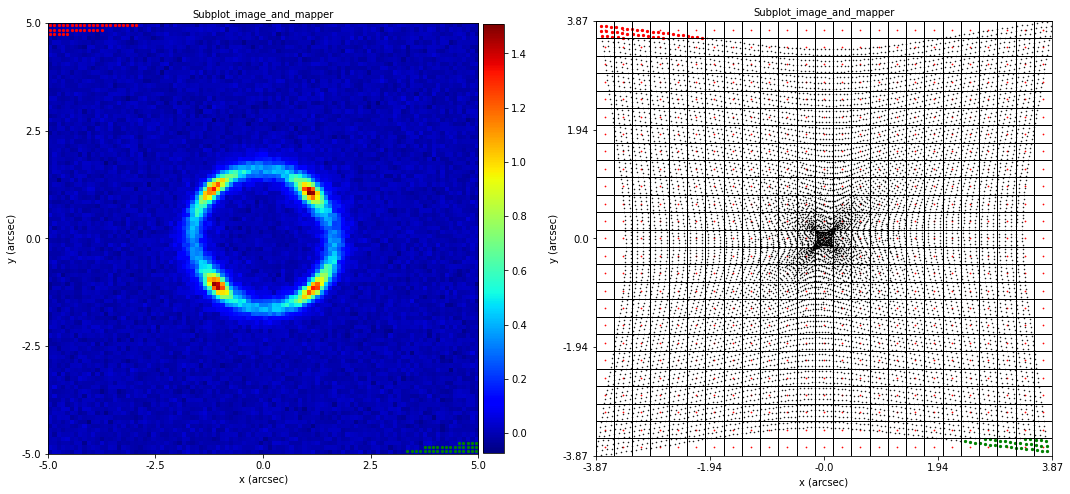

In [111]:
aplt.Mapper.subplot_image_and_mapper(
    image=imaging.image,
    mapper=mapper,
    include=aplt.Include(inversion_grid=True),
    source_pixel_indexes=[[0, 1, 2, 3, 4, 5, 6, 7], [620, 621, 622, 623, 624]],
)

Lets use an annular _Mask_, which will capture the ring-like shape of the lensed source galaxy.

In [112]:
mask = al.Mask.circular_annular(
    shape_2d=imaging.shape_2d,
    pixel_scales=imaging.pixel_scales,
    inner_radius=1.0,
    outer_radius=2.2,
)

Lets quickly confirm the annuli capture the source's light.

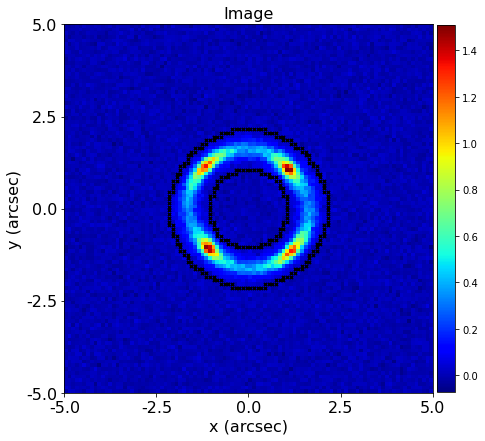

In [113]:
aplt.Imaging.image(imaging=imaging, mask=mask)

As usual, we setup our _Imaging_ and _Mask_ up as a _MaskedImaging_ object and create a _Tracer_ using the (masked) 
grid.

In [114]:
masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, al.Galaxy(redshift=1.0)])

source_plane_grid = tracer.traced_grids_of_planes_from_grid(grid=masked_imaging.grid)[1]

Finally, we use the masked source-plane _Grid_ to setup a new _Mapper_ (using the same rectangular 25 x 25 
_Pixelization_ as before).

In [115]:
mapper = rectangular.mapper_from_grid_and_sparse_grid(grid=source_plane_grid)

Lets have another look.

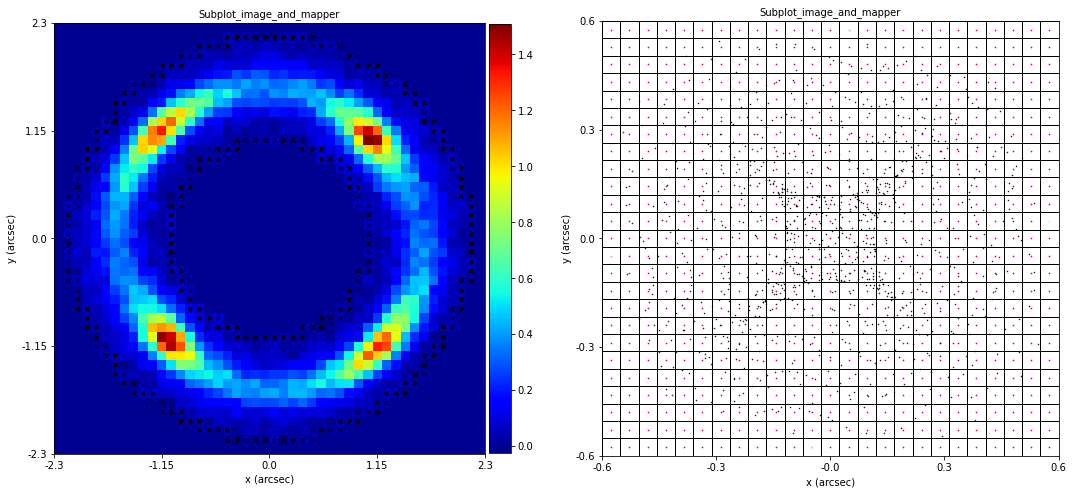

In [116]:
aplt.Mapper.subplot_image_and_mapper(
    image=masked_imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
)

Woah! Look how much closer we are to the source-plane (The axis sizes have decreased from ~ -2.5" -> 2.5" to 
~ -0.6" to 0.6"). We can now really see the diamond of points in the centre of the source-plane (for those who have 
been reading up, this diamond is called the 'caustic').

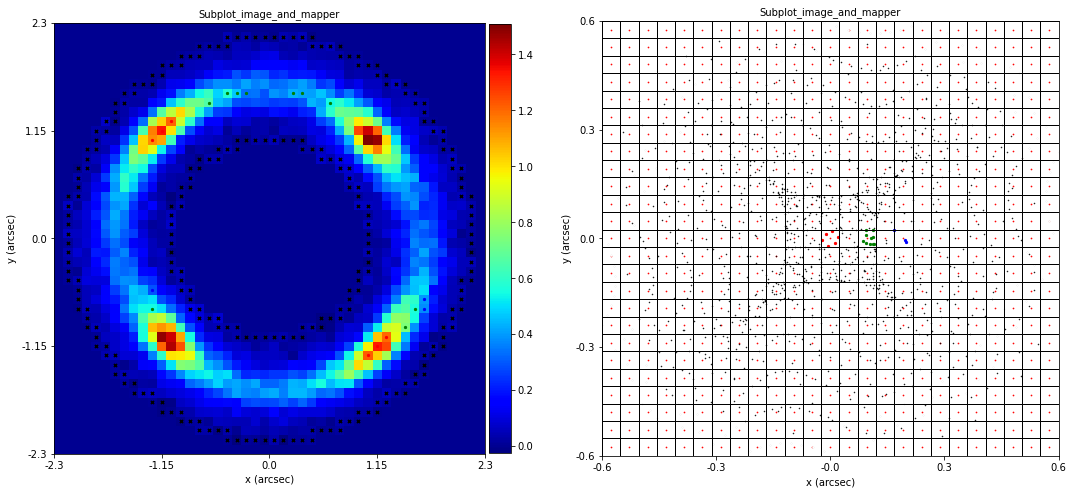

In [117]:
aplt.Mapper.subplot_image_and_mapper(
    image=masked_imaging.image,
    mapper=mapper,
    include=aplt.Include(mask=True, inversion_grid=True),
    source_pixel_indexes=[[312], [314], [316], [318]],
)

Great - tutorial 2 down! We've learnt about _Mapper_'s, which map things, and we used them to understand how the image 
and source plane map to one another.